In [3]:
import pandas as pd
import numpy as np

from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

import optuna

In [4]:
data = pd.read_csv(r"data/app.csv", sep=";")
df = data.copy()
df.head(2)

,time,users,sessions,newusers,crashes
0,22.12.18 09:00,64,60,5,0
1,22.12.18 10:00,79,84,8,0


In [6]:
#convert time column to datetime
df["time"] = pd.to_datetime(data["time"])
#set time as index and make sure its frequency to be hourly
df = df.set_index("time").asfreq("H")

## Base Model

In [7]:
def create_lag_features(df, col_name, lags, steps):
    df = df.copy()
    for i in range(1, lags):
        df[f"{col_name}_(t-{i})"] = df[col_name].shift(i)
    for i in range(1, steps+1):
        df[f"{col_name}_(t+{i})"] = df[col_name].shift(-i)
    df = df.dropna()
    return df

In [8]:
df = create_lag_features(df, "users", 24, 6)

In [9]:
X, y = df.loc[:, df.columns.str.contains('\(t\-')], df.loc[:, df.columns.str.contains('\(t\+')]

In [10]:
y = df.loc[:, df.columns.str.contains('\(t\+')]
X = df.drop(y.columns.to_list(), axis=1)

In [11]:
TR_SIZE = 0.8
tr_index = int(df.shape[0]*TR_SIZE)

X_tr = X[:tr_index]
y_tr = y[:tr_index]

X_tst = X[tr_index:]
y_tst = y[tr_index:]

print(f"""train size: {X_tr.shape[0]}\ntest size: {X_tst.shape[0]}""")

train size: 112
test size: 28


In [12]:
scaler = MinMaxScaler()

X_tr_scaled = scaler.fit_transform(X_tr)
X_tst_scaled = scaler.transform(X_tst)

In [13]:
model = ElasticNet(alpha=0.01, l1_ratio=0.1, random_state=42)
model.fit(X_tr_scaled, y_tr)
preds = model.predict(X_tst_scaled)


print(f"mape for train data: {mean_absolute_percentage_error(y_tr, model.predict(X_tr_scaled))}")
print(f"rmse for train data: {np.sqrt(mean_squared_error(y_tr, model.predict(X_tr_scaled)))}")
print(f"mape for test data: {mean_absolute_percentage_error(y_tst, preds)}")
print(f"rmse for test data: {np.sqrt(mean_squared_error(y_tst, preds))}")

mape for train data: 0.1738933306250651
rmse for train data: 13.602978655076084
mape for test data: 0.15949691149809697
rmse for test data: 15.08416200541323


In [14]:
df_preds = pd.DataFrame(preds, columns=y_tst.columns, index=y_tst.index)

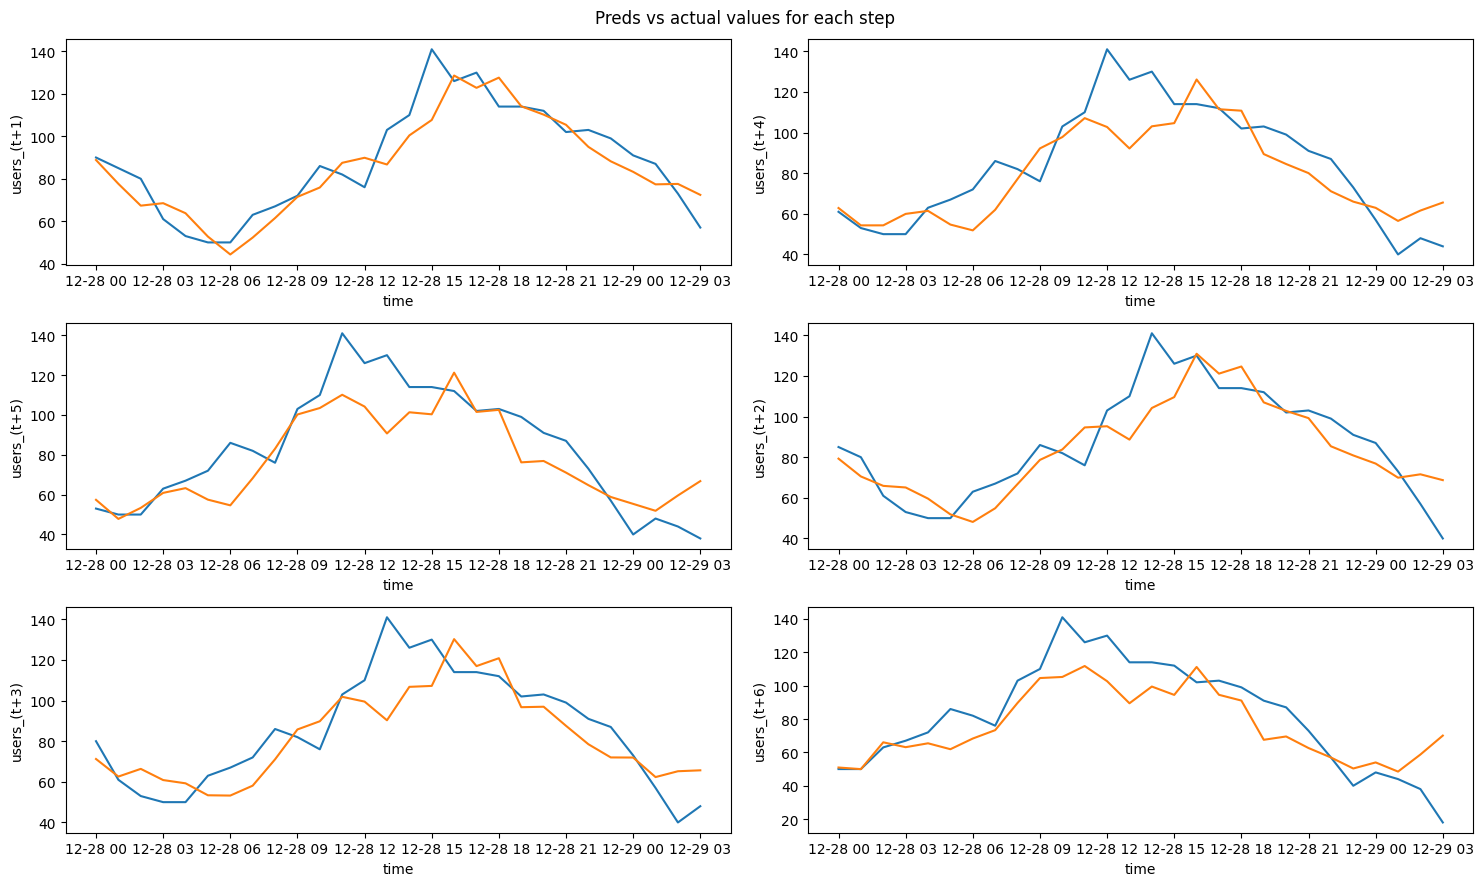

In [15]:
fig, axes = plt.subplots(3,2, figsize=(15,9), squeeze=False)
for i in range(0,y_tst.shape[1]):
    sns.lineplot(y_tst.iloc[:,i], ax=axes[i%3,i%2])
    sns.lineplot(df_preds.iloc[:,i], ax=axes[i%3,i%2])
plt.suptitle("Preds vs actual values for each step")
plt.tight_layout()
plt.show()

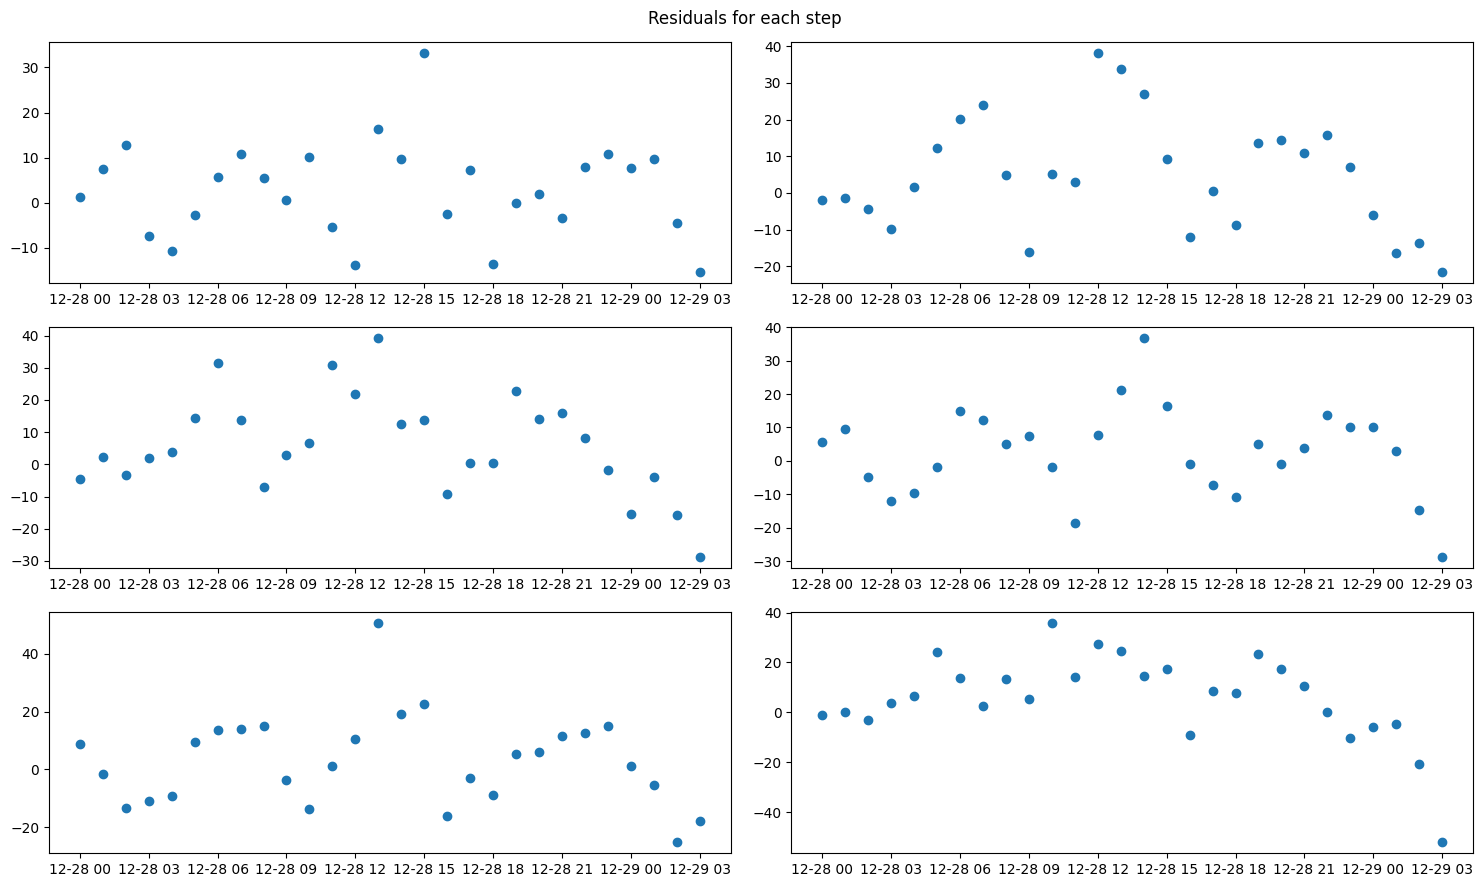

In [16]:
fig, axes = plt.subplots(3,2, figsize=(15,9), squeeze=False)
for i in range(0,y_tst.shape[1]):
    axes[i%3,i%2].scatter(y_tst.index,y_tst.iloc[:,i] - df_preds.iloc[:,i])
plt.suptitle("Residuals for each step")
plt.tight_layout()
plt.show()

Fit is not too bad, but residuals suggest that there is room for improvement.

In [17]:
VAL_SIZE = 0.2
tr_opt_index = int(X_tr.shape[0]*(1-VAL_SIZE))

X_tr_opt = X_tr[:tr_opt_index]
y_tr_opt = y_tr[:tr_opt_index]

X_val = X_tr[tr_opt_index:]
y_val = y_tr[tr_opt_index:]

scaler_opt = MinMaxScaler()

X_tr_opt_scaled = scaler_opt.fit_transform(X_tr_opt)
X_val_scaled = scaler_opt.transform(X_val)

def objective(trial):
    params = {
        'alpha' : trial.suggest_float('alpha', 0.001, 1),
        'l1_ratio' : trial.suggest_float('l1_ratio', 0.001, 1)        
    }

    reg = ElasticNet(**params, random_state=42).fit(X_tr_opt_scaled, y_tr_opt)
    preds_opt = reg.predict(X_val_scaled)
    score = np.sqrt(mean_squared_error(y_val, preds_opt))
    return score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=150)

[I 2022-12-12 22:06:08,114] A new study created in memory with name: no-name-1ca7c6af-0e6b-4d69-ae0e-88b6cc258a38
[I 2022-12-12 22:06:08,123] Trial 0 finished with value: 26.96011330640792 and parameters: {'alpha': 0.7871509771064362, 'l1_ratio': 0.9852286733305217}. Best is trial 0 with value: 26.96011330640792.
[I 2022-12-12 22:06:08,127] Trial 1 finished with value: 30.898155347439566 and parameters: {'alpha': 0.30308172004485473, 'l1_ratio': 0.06355558144072439}. Best is trial 0 with value: 26.96011330640792.
[I 2022-12-12 22:06:08,132] Trial 2 finished with value: 31.054737420242056 and parameters: {'alpha': 0.9298243088689552, 'l1_ratio': 0.8840661374649161}. Best is trial 0 with value: 26.96011330640792.
[I 2022-12-12 22:06:08,138] Trial 3 finished with value: 27.484620900010178 and parameters: {'alpha': 0.2975458381738748, 'l1_ratio': 0.6984039337276904}. Best is trial 0 with value: 26.96011330640792.
[I 2022-12-12 22:06:08,151] Trial 4 finished with value: 21.704986124163803 a

In [18]:
model_opt = ElasticNet(**study.best_params, random_state=42).fit(X_tr_scaled, y_tr)
preds_optimized = model_opt.predict(X_tst_scaled)

print(f"mape for train data: {mean_absolute_percentage_error(y_tr, model_opt.predict(X_tr_scaled))}")
print(f"rmse for train data: {np.sqrt(mean_squared_error(y_tr, model_opt.predict(X_tr_scaled)))}")
print(f"mape for test data: {mean_absolute_percentage_error(y_tst, preds_optimized)}")
print(f"rmse for test data: {np.sqrt(mean_squared_error(y_tst, preds_optimized))}")

mape for train data: 0.16166728673502992
rmse for train data: 12.712844649525115
mape for test data: 0.1811907101152328
rmse for test data: 17.278373189159556


In [19]:
df_preds_opt = pd.DataFrame(preds_optimized, columns=y_tst.columns, index=y_tst.index)

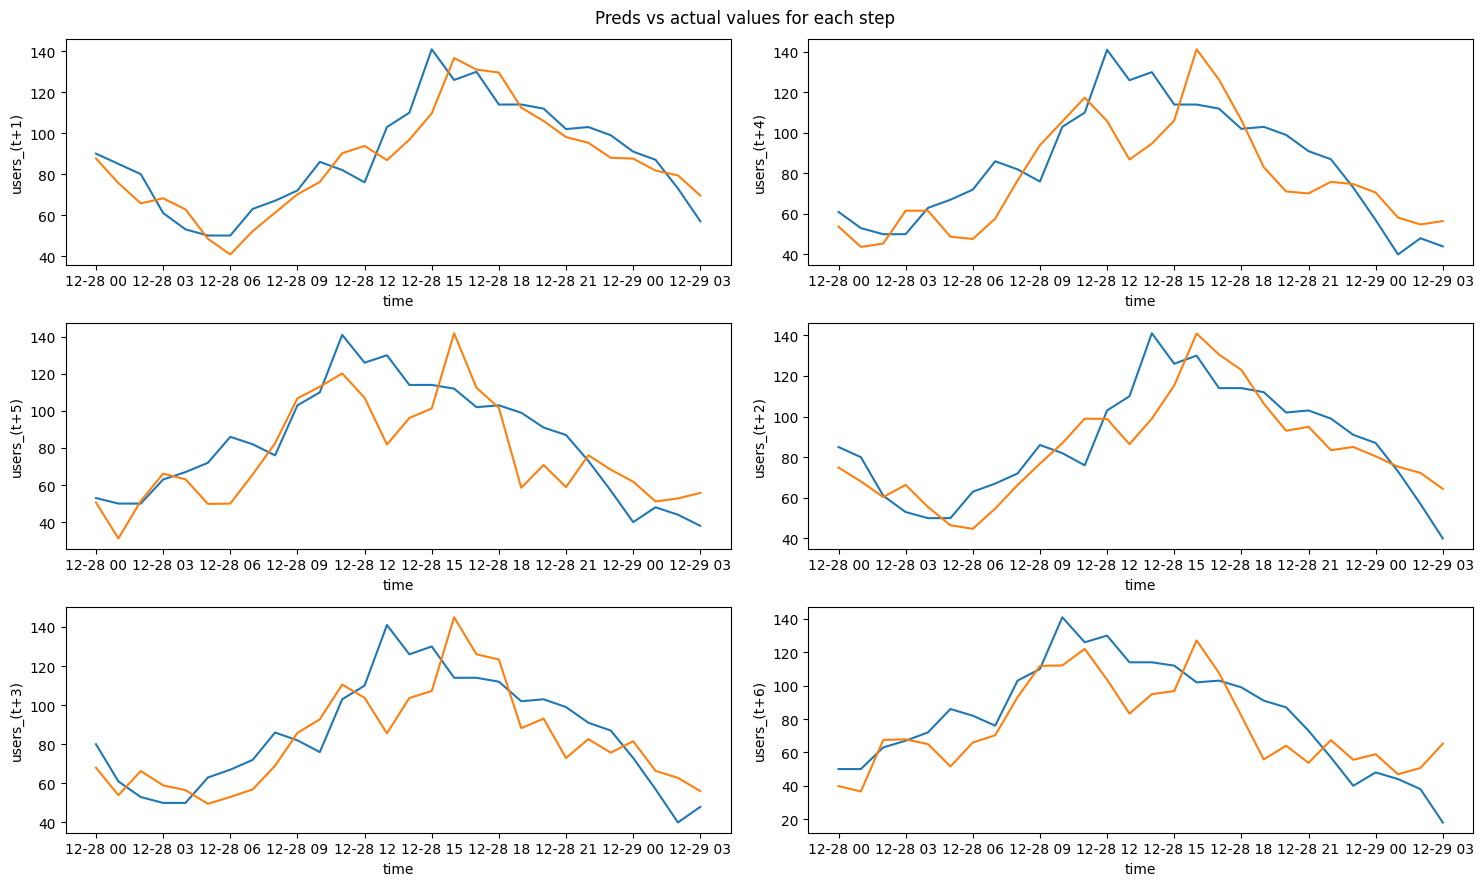

In [20]:
fig, axes = plt.subplots(3,2, figsize=(15,9), squeeze=False)
for i in range(0,y_tst.shape[1]):
    sns.lineplot(y_tst.iloc[:,i], ax=axes[i%3,i%2])
    sns.lineplot(df_preds_opt.iloc[:,i], ax=axes[i%3,i%2])
plt.suptitle("Preds vs actual values for each step")
plt.tight_layout()
plt.show()

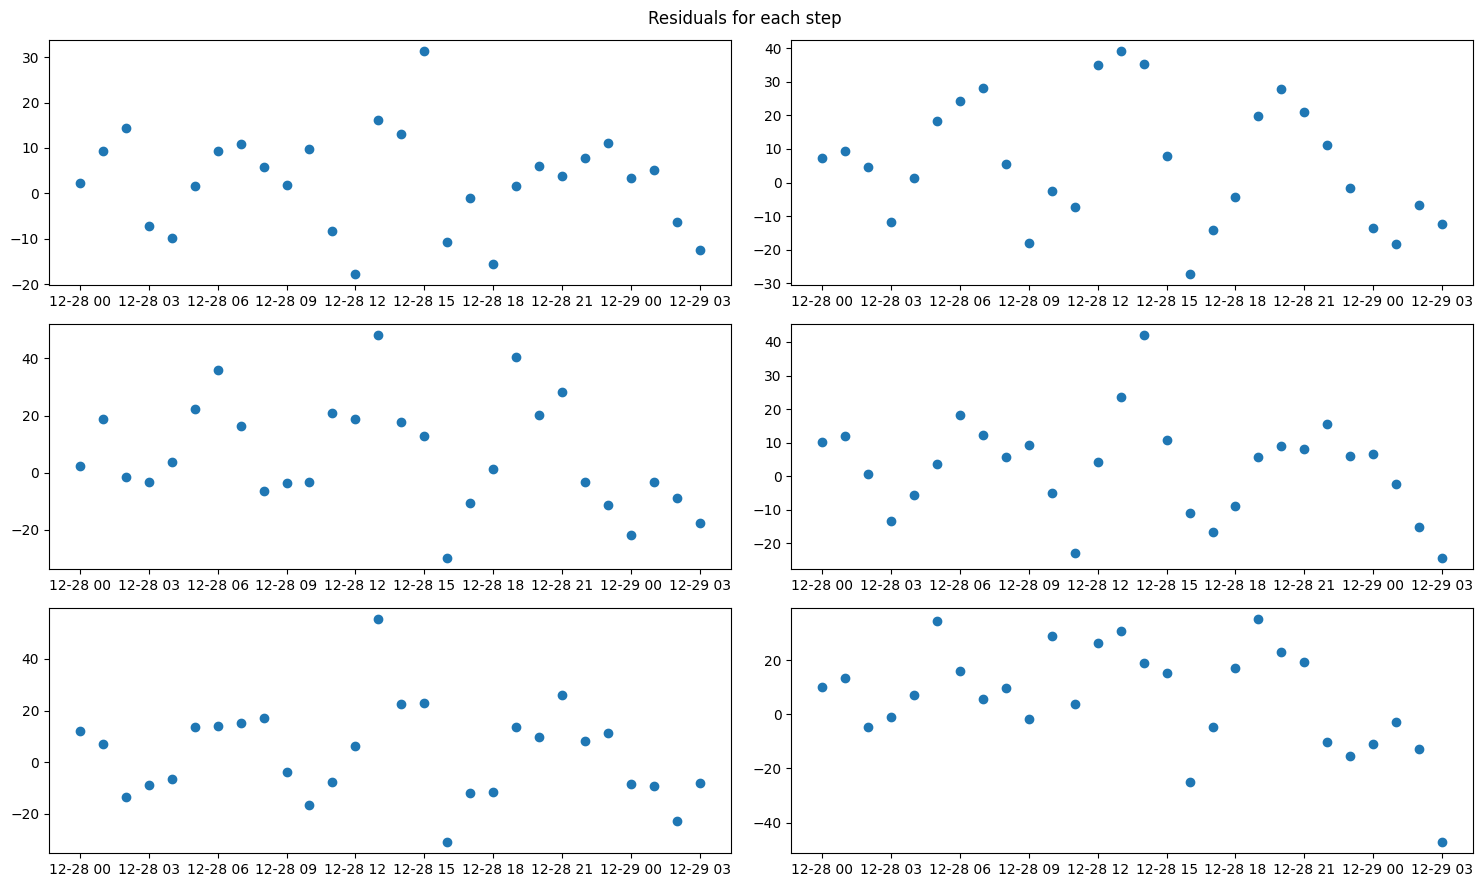

In [21]:
fig, axes = plt.subplots(3,2, figsize=(15,9), squeeze=False)
for i in range(0,y_tst.shape[1]):
    axes[i%3,i%2].scatter(y_tst.index,y_tst.iloc[:,i] - df_preds_opt.iloc[:,i])
plt.suptitle("Residuals for each step")
plt.tight_layout()
plt.show()

In [22]:
feat_importances = pd.DataFrame(model_opt.coef_, columns=X_tr.columns).T.sort_values([0,1,2,3,4,5], ascending=False)

In [23]:
all_preds = model_opt.predict(scaler.transform(X))
resids = y-all_preds

resids_tr = resids[:tr_index]
resids_tst = resids[tr_index:]

In [24]:
model_resid = MultiOutputRegressor(RandomForestRegressor(random_state=42))
model_resid = model_resid.fit(X_tr, resids_tr)
preds_resids = model_resid.predict(X_tst)


print(f"mape for train data: {mean_absolute_percentage_error(resids_tr, model_resid.predict(X_tr))}")
print(f"rmse for train data: {np.sqrt(mean_squared_error(resids_tr, model_resid.predict(X_tr)))}")
print(f"mape for test data: {mean_absolute_percentage_error(resids_tst, preds_resids)}")
print(f"rmse for test data: {np.sqrt(mean_squared_error(resids_tst, preds_resids))}")

mape for train data: 0.7882183274864478
rmse for train data: 4.42176348263969
mape for test data: 1.2075181599839229
rmse for test data: 16.148793698248213


Clearly overfitting the data!

In [25]:
resids_tr_opt = resids_tr[:tr_opt_index]
resids_val = resids_tr[tr_opt_index:]

def objective(trial):
    params = {
        'n_estimators' : trial.suggest_int('n_estimators', 10, 1000),
        'max_depth' : trial.suggest_int('max_depth', 4, 50),
        'min_samples_split' : trial.suggest_int("min_samples_split", 2, 150),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 2, 60)
    }

    reg = MultiOutputRegressor(
            RandomForestRegressor(random_state=42, **params)
        ).fit(X_tr_opt, resids_tr_opt)
    preds = reg.predict(X_val)
    score = np.sqrt(mean_squared_error(resids_val, preds))
    return score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2022-12-12 22:06:11,101] A new study created in memory with name: no-name-f793569f-9fb5-4c87-9b0f-b9cf230c9dec
[I 2022-12-12 22:06:12,976] Trial 0 finished with value: 13.921894626375265 and parameters: {'n_estimators': 815, 'max_depth': 30, 'min_samples_split': 80, 'min_samples_leaf': 53}. Best is trial 0 with value: 13.921894626375265.
[I 2022-12-12 22:06:15,247] Trial 1 finished with value: 17.39857325474429 and parameters: {'n_estimators': 740, 'max_depth': 32, 'min_samples_split': 13, 'min_samples_leaf': 9}. Best is trial 0 with value: 13.921894626375265.
[I 2022-12-12 22:06:15,521] Trial 2 finished with value: 13.97145104875911 and parameters: {'n_estimators': 119, 'max_depth': 50, 'min_samples_split': 150, 'min_samples_leaf': 57}. Best is trial 0 with value: 13.921894626375265.
[I 2022-12-12 22:06:16,668] Trial 3 finished with value: 13.963262373540756 and parameters: {'n_estimators': 503, 'max_depth': 25, 'min_samples_split': 106, 'min_samples_leaf': 49}. Best is trial 0 wit

In [26]:
model_resid_opt = MultiOutputRegressor(
        RandomForestRegressor(**study.best_params,random_state=42))
model_resid_opt = model_resid_opt.fit(X_tr, resids_tr)
preds_resids_opt = model_resid_opt.predict(X_tst)

print(f"mape for train data: {mean_absolute_percentage_error(resids_tr, model_resid_opt.predict(X_tr))}")
print(f"rmse for train data: {np.sqrt(mean_squared_error(resids_tr, model_resid_opt.predict(X_tr)))}")
print(f"mape for test data: {mean_absolute_percentage_error(resids_tst, preds_resids_opt)}")
print(f"rmse for test data: {np.sqrt(mean_squared_error(resids_tst, preds_resids_opt))}")

mape for train data: 1.0007190917529623
rmse for train data: 12.712862881211688
mape for test data: 1.0005637303884791
rmse for test data: 17.280254447593745


In [27]:
df_preds_resids = pd.DataFrame(preds_resids, index=resids_tst.index, columns=resids_tst.columns)

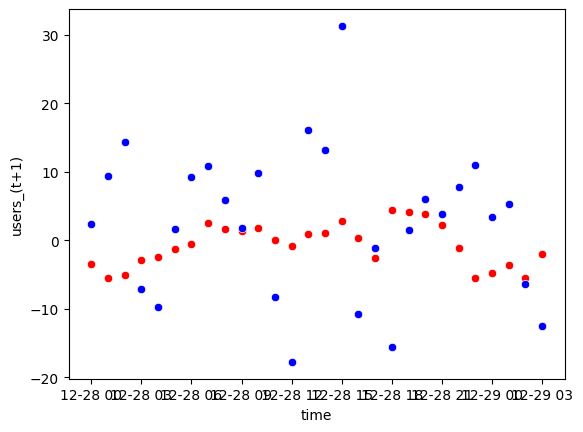

In [28]:
sns.scatterplot(df_preds_resids.loc[:,"users_(t+1)"], color="r")
sns.scatterplot(resids_tst.loc[:,"users_(t+1)"], color="b")
plt.show()

# Second Model

In [30]:
from warnings import simplefilter
simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

In [31]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [32]:
df_2 = data.copy()
df_2["time"] = pd.to_datetime(df_2["time"])
df_2 = df_2[["time","users","sessions"]].set_index("time")
df_2.head(2)

,users,sessions
time,,
2018-12-22 09:00:00,64,60
2018-12-22 10:00:00,79,84


In [33]:
dp = DeterministicProcess(
    index = df_2.index,
    constant = True,
    order = 1,
    drop = True,
    fourier=2
)

X = dp.in_sample()

In [34]:
idx_train, idx_test = train_test_split(
    df_2.index, test_size=48, shuffle=False,
)

idx_train.shape, idx_test.shape

((121,), (48,))

In [35]:
X_train, y_train = X.loc[idx_train, :], df_2.loc[idx_train, :]
X_test, y_test = X.loc[idx_test, :], df_2.loc[idx_test, :]

In [37]:
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)

y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

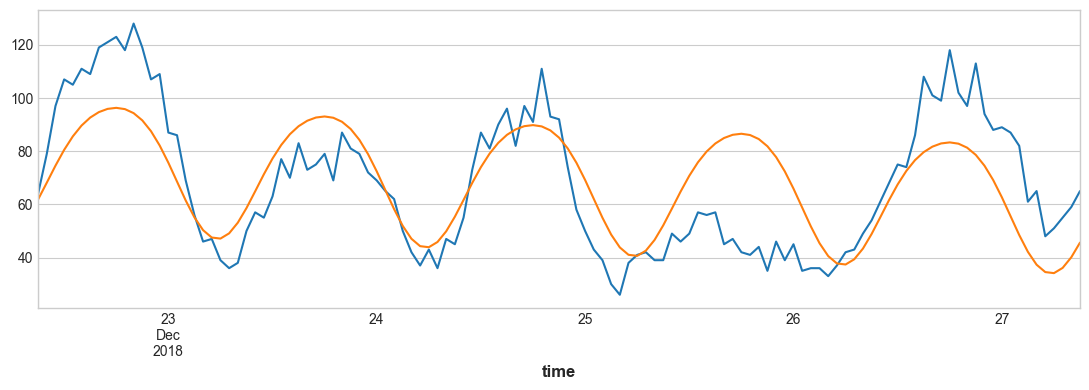

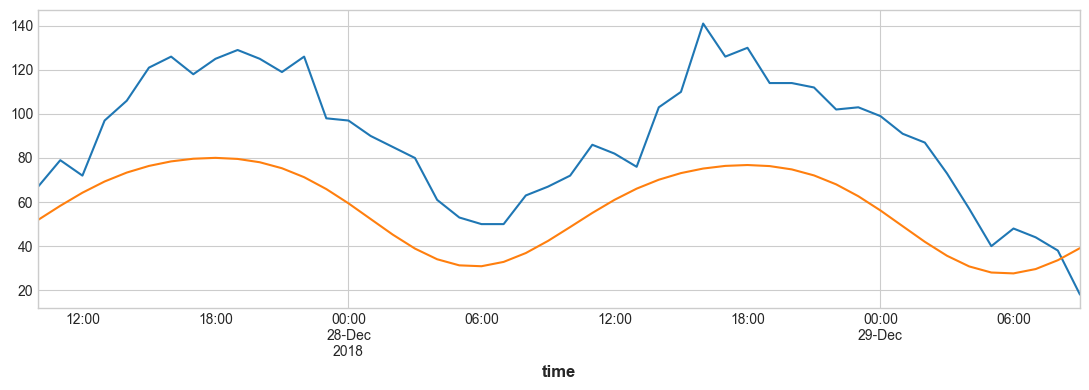

In [38]:
y_train.iloc[:,0].plot()
y_fit.iloc[:,0].plot()
plt.show()
y_test.iloc[:,0].plot()
y_pred.iloc[:,0].plot()
plt.show()

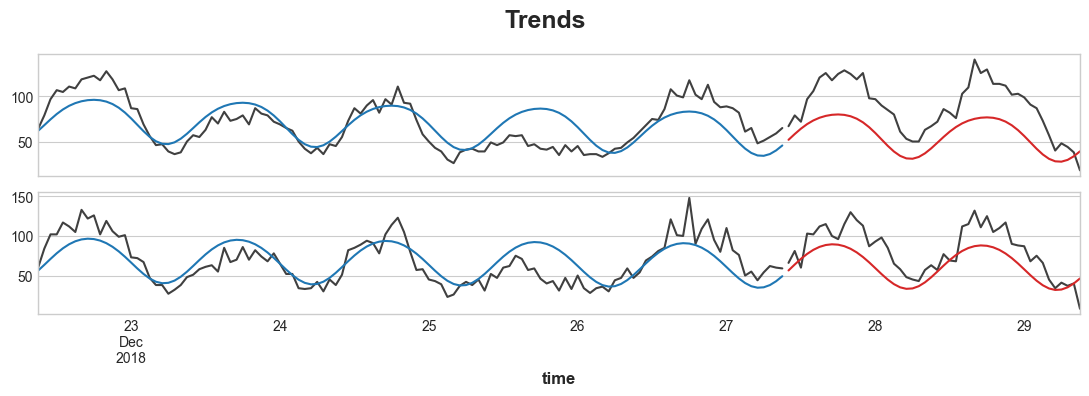

In [39]:
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

In [40]:
df_2 = pd.concat({'stats': df_2}, names=[None, 'columns'], axis=1)

In [42]:
X_xgb = df_2.stack()
y_xgb = X_xgb.pop("stats")

In [44]:
X_xgb.reset_index('columns', inplace=True)
for colname in X_xgb.select_dtypes(["object", "category"]):
    X_xgb[colname], _ = X_xgb[colname].factorize()

In [ ]:
X_xgb["hours"] = X_xgb.index.hour

In [ ]:
X_xgb_train, X_xgb_test = X_xgb.loc[idx_train, :], X_xgb.loc[idx_test, :]
y_xgb_train, y_xgb_test = y_xgb.loc[idx_train], y_xgb.loc[idx_test]

In [ ]:
y_fit=y_fit.stack().squeeze()
y_pred = y_pred.stack().squeeze()

In [ ]:
y_resid = y_xgb_train - y_fit

In [ ]:
from xgboost import XGBRegressor


xgb = XGBRegressor()
xgb.fit(X_xgb_train, y_resid)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [ ]:
y_fit_boosted = xgb.predict(X_xgb_train) + y_fit
y_pred_boosted = xgb.predict(X_xgb_test) + y_pred

In [ ]:
y_fit_boosted.unstack()

,users,sessions
time,,
2018-12-22 09:00:00,52.826411,47.174126
2018-12-22 10:00:00,60.203495,58.396489
2018-12-22 11:00:00,67.800216,71.599126
2018-12-22 12:00:00,76.198978,76.402744
2018-12-22 13:00:00,78.801889,82.397181
...,...,...
2018-12-27 05:00:00,41.399791,36.601731
2018-12-27 06:00:00,43.202575,41.796646
2018-12-27 07:00:00,42.394695,41.805338


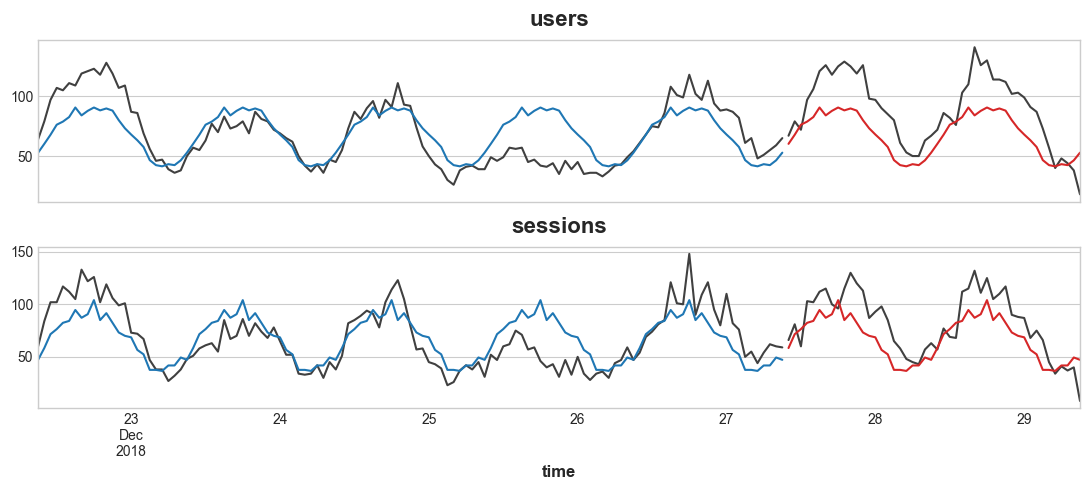

In [ ]:
axs = y_xgb_train.unstack(['columns']).plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=['users', 'sessions'],
)
axs = y_xgb_test.unstack(['columns']).plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.unstack().plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.unstack().plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])

In [ ]:
print(f"mape for train data: {mean_absolute_percentage_error(y_test['users'],y_pred_boosted.unstack()['users'])}")
print(f"mape for train data: {np.sqrt(mean_squared_error(y_test['users'],y_pred_boosted.unstack()['users']))}")

# print(f"rmse for train data: {np.sqrt(mean_squared_error(resids_tr, model_resid_opt.predict(X_tr)))}")
# print(f"mape for test data: {mean_absolute_percentage_error(resids_tst, preds_resids_opt)}")
# print(f"rmse for test data: {np.sqrt(mean_squared_error(resids_tst, preds_resids_opt))}")

mape for train data: 0.2677760717327012
mape for train data: 26.02779762996493
